## Derivatives

Formulas provided

\begin{align}
\\O_1 = \sigma \left (\sum_{i=1}W_{2,1i}H_i+b_{O,1} \right)\\
\sigma = \frac{1}{1+\exp(-x)}\\
\\C = 0.5 \sum_{i=1} ||O(I_i)-t_i ||\\
\end{align}

Implied formula for hidden

\begin{align}
\\H_i = \sigma \left ( \sum_{j=1} W_{1,ij}\times I_{ij} + b_{h,i} \right )\\
\end{align}

### 1

\begin{align}
\\C = 0.5 \sum_{i=1} (O(I_i)-t_i)^2 \\
\frac{\\dC}{\\dO_1(I_i)} = \sum_{i=1} (O_1(I_i)-t_i) \times 1\\
\frac{\\dC}{\\dO_1(I_i)} = \sum_{i=1} (O_1(I_i)-t_i)\\
\end{align}

### 2

\begin{align}
\\O_1 = \sigma \left (\sum_{i=1}W_{2,1i}H_i+b_{O,1} \right)\\
\frac{\\dO_{1}}{\\dW_{2,1i}} = \sigma' \left (\sum_{i=1}(W_{2,1i}H_i+b_{O,1} \right)\times H_i\\
\end{align}

### 3

\begin{align}
\\O_1 = \sigma \left (\sum_{i=1}W_{2,1i}H_i+b_{O,1} \right)\\
\\O_1 = \sigma \left (\sum_{i=1} W_{2,1i}\times \sigma \left ( \sum_{j=1}W_{1,ij}\times I_{ij} + b_{h,i} \right)+b_{O,1} \right )\\
\frac{\\dO_{1}}{\\dW_{1,ij}} = \sigma'\left (\sum_{i=1} W_{2,1i}\times \sigma \left ( \sum_{j=1}W_{1,ij}\times I_{ij} + b_{h,i} \right)+b_{O,1} \right )\times \left ( W_{2,1i}\times \sigma' \left ( \sum_{j=1}W_{1,ij}\times I_{ij} + b_{h,i} \right) \right )\times I_{ij}
\end{align}

### 4

\begin{align}
\\O_1 = \sigma \left (\sum_{i=1}W_{2,1i}H_i+b_{O,1} \right)\\
\\O_1 = \sigma \left (\sum_{i=1} W_{2,1i}\times \sigma \left ( \sum_{j=1}W_{1,ij}\times I_{ij} + b_{h,i} \right)+b_{O,1} \right )\\
\frac{\\dO_{1}}{\\b_{h,i}} = \sigma' \left (\sum_{i=1}W_{2,1i}\times \sigma \left (\sum_{j=1}W_{1,ij}\times I_{ij} + b_{h,i} \right )+b_{O,1} \right)\times \left(W_{2,1i}\times \sigma' \left (\sum_{j=1}W_{1,ij}\times I_{ij} + b_{h,i} \right ) \right ) \times 1 \\
\frac{\\dO_{1}}{\\b_{h,i}} = \sigma' \left (\sum_{i=1}W_{2,1i}\times \sigma \left (\sum_{j=1}W_{1,ij}\times I_{ij} + b_{h,i} \right )+b_{O,1} \right)\times \left(W_{2,1i}\times \sigma' \left (\sum_{j=1}W_{1,ij}\times I_{ij} + b_{h,i} \right ) \right ) \\
\end{align}

### 5

The goal is to minimize the cost function, the output1 (prediction) minus the actual value. In order to minimize this function, we need to optimize the weight matrices that are used to calculate the output. Thus, each partial derivative listed above optimizes the matrices with respect to this cost function to ultimately minimize the prediction error. Therefore, with each iteration, the weight matrices are adjusted in a way to move towards the direction of the minimal value of the cost function. These partial derivatives allow us to move the weights appropriately.

## "Matlab"

In [1]:
from __future__ import division
import os
import numpy as np
import random 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, linear_model, metrics
%matplotlib inline
import collections
import math

In [2]:
sns.set(context='notebook',style='ticks')

Functions

In [3]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoid_prime = lambda x: np.multiply(sigmoid(x),(1 - sigmoid(x)))

def ann_backprop_error(target, states, inp, weights, biases):
    backp = {i:[] for i in xrange(len(states))}
    end = len(states)-1
    backp[end] = (states[end] - target)*sigmoid_prime(weights[end].dot(states[end-1]) + biases[end]) 
    # move error to early layers of network:
    for i in xrange(1,len(backp)-1):
        sigma_term = sigmoid_prime(weights[end].dot(states[end-i]) + biases[end-i])
        backp[end-i] = np.multiply(weights[end].T.dot(backp[end-i+1]), sigma_term)
    #at end: do the calculation using input:
    sigma_term = sigmoid_prime(weights[0].dot(inp) + biases[0])
    backp[0] = weights[1].T.dot(backp[1]) * sigma_term
    return(backp)

def ann_bias_deriv(backp):
#% Calculates the derivative of the cost function wrt biases of
#% hidden/output layers

#% Input variables: 
#% backp = backpropagated error from ann_backprop_error

#% Output:
#% derivatives wrt biases... shape = shape(backp)

    db = {i:[] for i in range(len(backp))}
    for i in xrange(len(backp)):
        db[i] = backp[i]
    return(db)

def ann_feedforward(inp, weights, biases):
# Calculates the states of the hidden and output neurons

# Input variables: see ann_backprop_error


    cur_state = inp
    states = {}
    for i in xrange(len(weights)):
        cur_state = sigmoid(weights[i].dot(cur_state) + biases[i])
        if i not in states:
            states[i] = cur_state
    return(states)

def ann_weight_deriv(backp, inp, states, weights):
    #% Calculates the derivative of the cost function wrt connectivity weights
    #% Essentially: does dC/dwij for every weight in the network

    #% Input variables: 
    #% backp = backpropagated error from ann_backprop_error
    #% for rest of variables, see ann_backprop_error

    # Output:
    # derivatives wrt W's... shape = shape(weights)


    dw = {}

    #% iterate through backprop errors:
    for i in range(1,len(backp)):
        cur_w = weights[i]
        dw_in = np.zeros(cur_w.shape)
        len1, len2 = cur_w.shape
        for j in range(len1):
            for k in range(len2):
                dw_in[j,k] = states[i-1].item(k) * backp[i].item(j)
        if i not in dw:
            dw[i] = dw_in
            
    #% do 1st layer of errors:
    cur_w = weights[0]
    dw_in = np.zeros(cur_w.shape)
    len1, len2 = cur_w.shape
    for j in xrange(len1):
        for k in xrange(len2):
            dw_in[j,k] = inp.item(k) * backp[0].item(j)
    if 0 not in dw:
        dw[0] = dw_in
    return(dw)
errnn = lambda pred,actual: (pred-actual)**2

### 6

In [4]:
def train_ann(patterns,targets,weights,biases,epoch,alpha):
    '''
    patterns: data matrix with each row mapping to a target
    targets: 1-d array with nrows = patterns.shape[1]
    weights: a dictionary initialized with layer weights matching dimensions such that the matrix multiplication
    between the weights of the hidden layers gives the desired hidden layer size. 
    Weights are randomly distributed centered around 0
    biases: a dictionary initialized with bias vector, matching dimensions of the hidden layers. Values are all given 1
    NOTE: Weights and biases must share the same key for each hidden layer.
    epoch: integer, number of iterations of forward/back propagation for all input patterns
    alpha: learning rate, float
    
    returns: cost per epoch, the average error, the trained weights and the trained biases dictionary
    '''
    np.random.seed(seed=8)
    cost_epoch=[]
    avrgerror_per_epoch = []
    for e in xrange(epoch):
        epoch_iter_oneperm = []
        epoch_iter_oneperm_error = []
        for ind in np.random.choice(len(patterns),4,replace=False):
            inp = patterns[ind][np.newaxis].T
            target = targets[ind]
            cur_state = inp
            states = ann_feedforward(inp, weights, biases)
            backp = ann_backprop_error(target,states,inp,weights,biases)
            dw = ann_weight_deriv(backp, inp, states, weights)
            d_biases = ann_bias_deriv(backp)
            for w in weights:
                weights[w] = weights[w]-alpha * dw[w] 
            for d in biases:
                biases[d] = biases[d] - alpha * d_biases[d]
            err_epoch_iter = errnn(states[len(states)-1],target)
            epoch_iter_oneperm.append(err_epoch_iter)
            epoch_iter_oneperm_error.append(err_epoch_iter)
        cost_epoch.append(np.sum(epoch_iter_oneperm)*0.5)
        avrgerror_per_epoch.append(np.mean(epoch_iter_oneperm_error))
    return(cost_epoch,avrgerror_per_epoch,weights,biases)

In [5]:
def predict_using_ann(patterns,weights,biases):
    """
    Performs feed forward propogation with the trained weights and biases, returns the predictions according to the 
    pattern
    patterns: numpy array
    weights: dictionary described above
    biases: dictionary decribed above
    """
    predictions = []
    for inp in patterns:
        cur_state = inp[np.newaxis].T
        for i in range(len(weights)-1):
            cur_state = sigmoid(weights[i].dot(cur_state)+biases[i])
        pred = sigmoid(weights[len(weights)-1].dot(cur_state)+biases[len(weights)-1])
        predictions.append(pred)
    return np.array(predictions).flatten()

#### Note "mean cost per epoch" is the simply mean( predicted-actual)**2). I was just curious what it looked like, but the cost per epoch would be the answer to the question listed on the final (the second panel for all plots)

### 7

In [38]:
patterns[0][np.newaxis].T

array([[ 0.1],
       [ 0. ]])

In [43]:
weights[0].dot(patterns[0])+biases[0].T

array([[ 0.19056975, -1.5567396 ,  3.24393916]])

In [6]:
epoch = 10000
alpha = 0.8
patterns = np.array([[0,0],[0,1], [1,0],[1,1]])
targets = np.array([[0, 1, 1, 1]]).T
weights = {}
layer_sizes = [(3, 2), (1, 3)]
for i,x in enumerate(layer_sizes):
    if i not in weights:
        weights[i] =  2*np.random.random((layer_sizes[i][0],layer_sizes[i][1])) - 1
    i=i+1
biases = {}
for i,x in enumerate(layer_sizes):
    if i !=len(layer_sizes)-1:
        biases[i] = np.ones(weights[i].shape[0])[np.newaxis].T
    else:
        biases[i] = np.ones(weights[i].shape[0])
cost_epoch_or,error_epoch_or,weights_or,biases_or = train_ann(patterns,targets,weights,biases,epoch,alpha)

Making sure it predictions look acceptable for the patterns

In [7]:
patterns = np.array([[0,0],[0,1], [1,0],[1,1]])
targets = np.array([[0, 1, 1, 1]]).T
predict_using_ann(patterns,weights_or,biases_or)

array([ 0.00832104,  0.99319557,  0.99337081,  0.99873906])

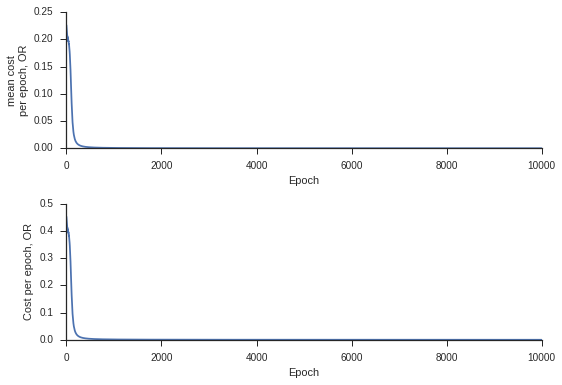

In [8]:
f,ax = plt.subplots(2,1)
plotdict = {'Cost per epoch':cost_epoch_or,'mean cost\nper epoch':[x for x in error_epoch_or]}
for i,lab in enumerate(plotdict):
    axes = ax[i]
    vec = plotdict[lab]
    axes.plot(range(epoch),vec)
    axes.set_xlabel('Epoch')
    axes.set_ylabel('{}, OR'.format(lab))
f.tight_layout()
sns.despine()
plt.show()
plt.close()

### 8

In [9]:
epoch = 10000
alpha = 0.1
patterns = np.array([[0,0],[0,1], [1,0],[1,1]])
targets = np.array([[0, 1, 1, 0]]).T
layer_sizes = [(3, 2), (1, 3)]
weights = {}
for i,x in enumerate(layer_sizes):
    if i not in weights:
        weights[i] =  2*np.random.random((layer_sizes[i][0],layer_sizes[i][1])) - 1
    i=i+1
biases = {}
for i,x in enumerate(layer_sizes):
    if i !=len(layer_sizes)-1:
        biases[i] = np.ones(weights[i].shape[0])[np.newaxis].T
    else:
        biases[i] = np.ones(weights[i].shape[0])
cost_epoch_xor,errors_epoc_xor,weights_xor,biases_xor = train_ann(patterns,targets,weights,biases,epoch,alpha)

Making sure the predictions look acceptable with the final trained ANN

In [10]:
patterns = np.array([[0,0],[0,1], [1,0],[1,1]])
targets = np.array([[0, 1, 1, 0]]).T
predict_using_ann(patterns,weights_xor,biases_xor)

array([ 0.02758973,  0.9476917 ,  0.9500205 ,  0.06113934])

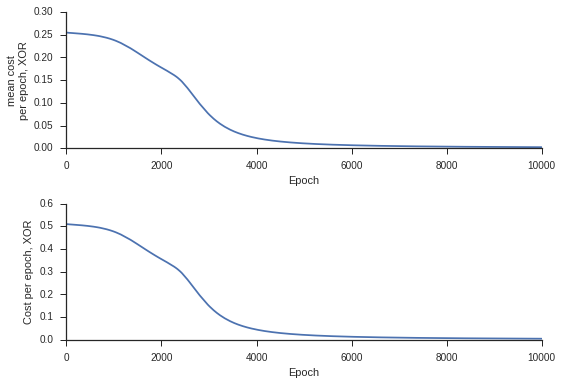

In [11]:
f,ax = plt.subplots(2,1)
plotdict = {'Cost per epoch':cost_epoch_xor,'mean cost\nper epoch':[x for x in errors_epoc_xor]}
for i,lab in enumerate(plotdict):
    axes = ax[i]
    vec = plotdict[lab]
    axes.plot(range(epoch),vec)
    axes.set_xlabel('Epoch')
    axes.set_ylabel('{}, XOR'.format(lab))
f.tight_layout()
sns.despine()
plt.show()
plt.close()

### 9

In [47]:
layer_sizes = [(3, 2), (1, 3)]
epoch = 10000
alpha = 0.1
patterns = np.array([[0,0],[0,1], [1,0],[1,1]])
targets = np.array([[0, 1, 1, 1]]).T
weights  = {}
for i,x in enumerate(layer_sizes):
    if i not in weights:
        weights[i] =  5*np.random.random((layer_sizes[i][0],layer_sizes[i][1]))
    i=i+1
biases = {}
for i,x in enumerate(layer_sizes):
    if i !=len(layer_sizes)-1:
        biases[i] = np.ones(weights[i].shape[0])[np.newaxis].T
    else:
        biases[i] = np.ones(weights[i].shape[0])
cost_epoch_biggerW_or,error_epoch_biggerW_or,weights_biggerW_or,biases_biggerW_or = train_ann(patterns,targets,weights,biases,epoch,alpha)

Making sure the predictions look acceptable with the final trained ANN

In [48]:
patterns = np.array([[0,0],[0,1], [1,0],[1,1]])
targets = np.array([[0, 1, 1, 1]]).T
predict_using_ann(patterns,weights_biggerW_or,biases_biggerW_or)

array([ 0.03769822,  0.98069531,  0.97989458,  0.99637433])

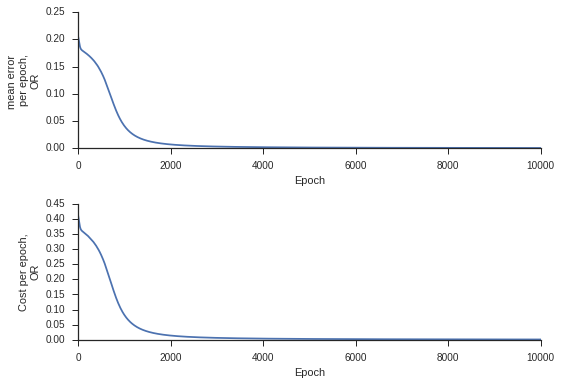

In [49]:
f,ax = plt.subplots(2,1)
plotdict = {'Cost per epoch':cost_epoch_biggerW_or,'mean error \nper epoch':error_epoch_biggerW_or}
for i,k in enumerate(plotdict):
    plotvec = plotdict[k]
    axes = ax[i]
    axes.plot(range(epoch),plotvec)
    axes.set_xlabel('Epoch')
    axes.set_ylabel('{},\nOR'.format(k))
sns.despine()
f.tight_layout()
plt.show()
plt.close()

In [44]:
layer_sizes = [(3, 2),(2,3),(1, 2)]
epoch = 50000
alpha = 0.8
patterns = np.array([[0,0],[0,1], [1,0],[1,1]])
targets = np.array([[0, 1, 1, 0]]).T
weights = {}
for i,x in enumerate(layer_sizes):
    if i not in weights:
        weights[i] =  5*np.random.random((layer_sizes[i][0],layer_sizes[i][1]))
    i=i+1
biases = {}
for i,x in enumerate(layer_sizes):
    if i !=len(layer_sizes)-1:
        biases[i] = np.ones(weights[i].shape[0])[np.newaxis].T
    else:
        biases[i] = np.ones(weights[i].shape[0])
cost_epoch_biggerW_xor,error_epoch_biggerW_xor,weights_biggerW_xor,biases_biggerW_xor = train_ann(patterns,targets,weights,biases,epoch,alpha)

In [45]:
patterns = np.array([[0,0],[0,1], [1,0],[1,1]])
targets = np.array([[0, 1, 1, 0]]).T
predict_using_ann(patterns,weights_biggerW_xor,biases_biggerW_xor)

array([ 0.00780429,  0.9901368 ,  0.99044721,  0.01139191])

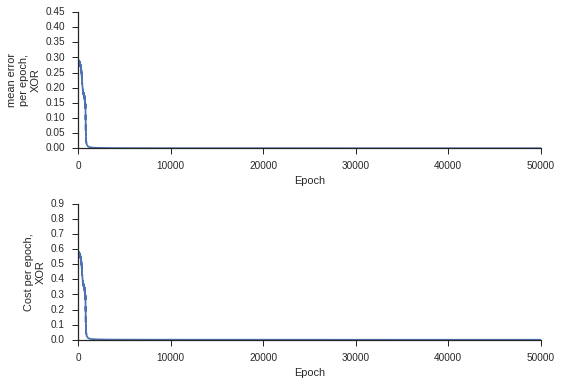

In [46]:
f,ax = plt.subplots(2,1)
plotdict = {'Cost per epoch':cost_epoch_biggerW_xor,'mean error\nper epoch':error_epoch_biggerW_xor}
for i,k in enumerate(plotdict):
    plotvec = plotdict[k]
    axes = ax[i]
    axes.plot(range(epoch),plotvec)
    axes.set_xlabel('Epoch')
    axes.set_ylabel('{},\nXOR'.format(k))
sns.despine()
f.tight_layout()
plt.show()
plt.close()

### 10 Bonus - noisy OR

In [18]:
layer_sizes = [(3, 2), (1, 3)]
epoch = 50000
alpha = 0.1
patterns = np.array([[0.2,0.1],[0.1,1.1], [0.8,0.2],[1.1,0.9]])
targets = np.array([[0, 1, 1, 1]]).T
weights = {}
for i,x in enumerate(layer_sizes):
    if i not in weights:
        weights[i] =  2*np.random.random((layer_sizes[i][0],layer_sizes[i][1]))-1
    i=i+1
biases = {}
for i,x in enumerate(layer_sizes):
    if i !=len(layer_sizes)-1:
        biases[i] = np.ones(weights[i].shape[0])[np.newaxis].T
    else:
        biases[i] = np.ones(weights[i].shape[0])
cost_epoch_noisy_or,error_epoch_noisy_or,weights_noisy_or,biases_noisy_or = train_ann(patterns,targets,weights,biases,epoch,alpha)

In [19]:
patterns = np.array([[0.2,0.1],[0.1,1.1], [0.8,0.2],[1.1,0.9]])
targets = np.array([[0, 1, 1, 1]]).T
predict_using_ann(patterns,weights_noisy_or,biases_noisy_or)

array([ 0.01320688,  0.99233566,  0.98739654,  0.99854104])

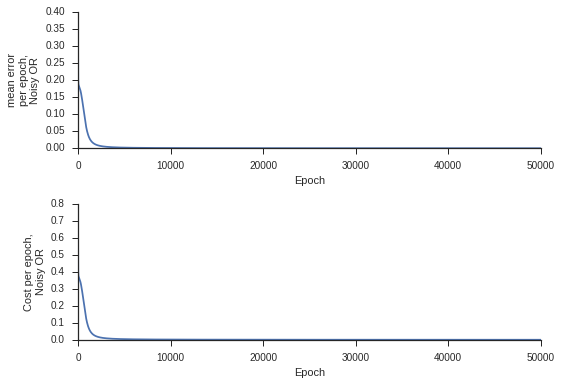

In [20]:
f,ax = plt.subplots(2,1)
plotdict = {'Cost per epoch':cost_epoch_noisy_or,'mean error\nper epoch':error_epoch_noisy_or}
for i,k in enumerate(plotdict):
    plotvec = plotdict[k]
    axes = ax[i]
    axes.plot(range(epoch),plotvec)
    axes.set_xlabel('Epoch')
    axes.set_ylabel('{},\nNoisy OR'.format(k))
sns.despine()
f.tight_layout()
plt.show()
plt.close()

### 10-Noisy XOR

In [21]:
epoch = 50000
alpha = 0.1
patterns = np.array([[0.1,0],[0.2,0.8], [1.1,0.1],[0.8,1.1]])
targets = np.array([[0, 1, 1, 0]]).T
layer_sizes = [(3, 2), (1, 3)]
weights = {}
for i,x in enumerate(layer_sizes):
    if i not in weights:
        weights[i] =  2*np.random.random((layer_sizes[i][0],layer_sizes[i][1])) - 1
    i=i+1
biases = {}
for i,x in enumerate(layer_sizes):
    if i !=len(layer_sizes)-1:
        biases[i] = np.ones(weights[i].shape[0])[np.newaxis].T
    else:
        biases[i] = np.ones(weights[i].shape[0])
cost_epoch_noisy_xor,errors_epoc_noisy_xor,weights_noisy_xor,biases_noisy_xor = train_ann(patterns,targets,weights,biases,epoch,alpha)

In [22]:
patterns = np.array([[0.1,0],[0.2,0.8], [1.1,0.1],[0.8,1.1]])
targets = np.array([[0, 1, 1, 0]]).T
predict_using_ann(patterns,weights_noisy_xor,biases_noisy_xor)

array([ 0.01231446,  0.98124731,  0.98166854,  0.02083152])

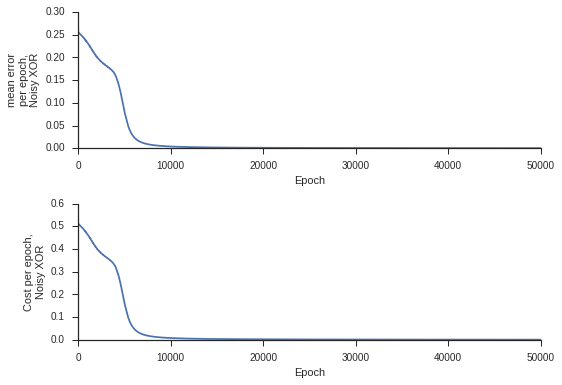

In [23]:
f,ax = plt.subplots(2,1)
plotdict = {'Cost per epoch':cost_epoch_noisy_xor,'mean error\nper epoch':errors_epoc_noisy_xor}
for i,k in enumerate(plotdict):
    plotvec = plotdict[k]
    axes = ax[i]
    axes.plot(range(epoch),plotvec)
    axes.set_xlabel('Epoch')
    axes.set_ylabel('{},\nNoisy XOR'.format(k))
sns.despine()
f.tight_layout()
plt.show()
plt.close()